Author: Ani Aggarwal  
Github: www.github.com/AniAggarwal

In [1]:
import librosa
import librosa.display

from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import csv
import json

import IPython.display as ipd

from create_dataset import denoise_audio_np, process_audio_file

In [2]:
DOWN_SR = 1000
BPF_LOW = 20
BPF_HIGH = 400
BPF_ORDER = 3
DATA_SR = 44100

AUDIO_LEN = 1  # in seconds
num_samples = AUDIO_LEN * DOWN_SR

In [3]:
train_path = Path("./datasets/segmentation/heartbeat-sounds-kaggle/set_a/")
audio_path = train_path / "normal__201102081321.wav"

In [4]:
audio, _ = librosa.load(audio_path, sr=DOWN_SR)

In [5]:
audio = denoise_audio_np(audio, bpf_high=195)

<Figure size 2880x720 with 0 Axes>

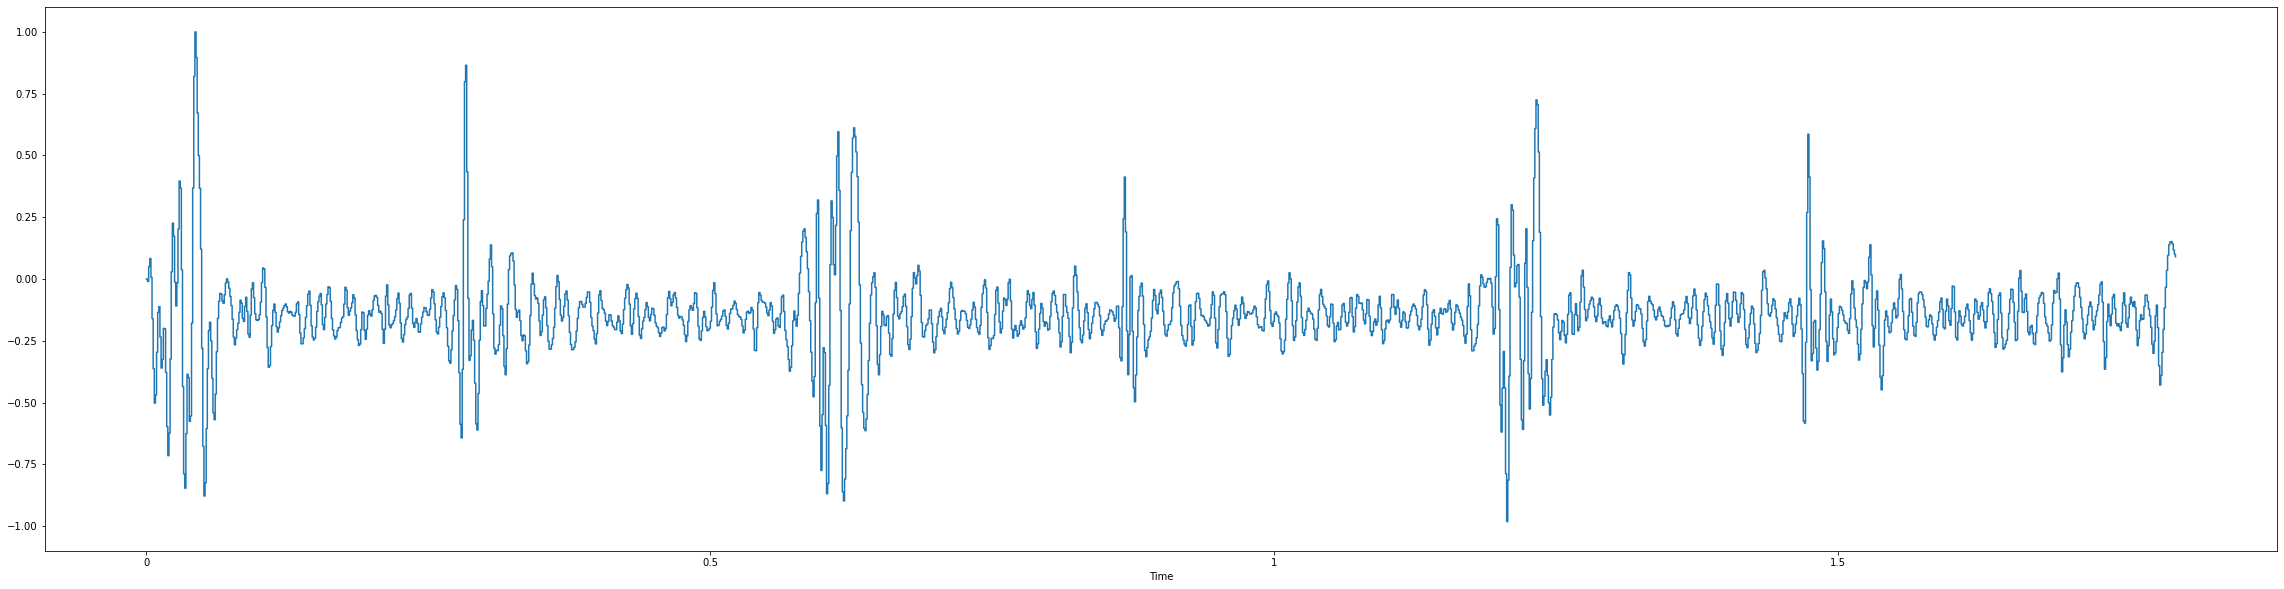

In [6]:
plt.figure(figsize=(40, 10))
librosa.display.waveshow(audio[200:2000], sr=DOWN_SR)

In [7]:
n_fft = int(0.025 * DOWN_SR)
hop_len = int(0.01 * DOWN_SR)
    
mfcc = librosa.feature.mfcc(
    audio, DOWN_SR, n_fft=n_fft, hop_length=hop_len, n_mfcc=13
)
mfcc = mfcc.T

C:\Anaconda3\miniconda3\envs\flow\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [8]:
mfcc.shape

(789, 13)

# MFCC Shape
len = len(audio) / hop_len

Text(0.5, 0, 'Time')

Text(0, 0.5, 'MFCC')

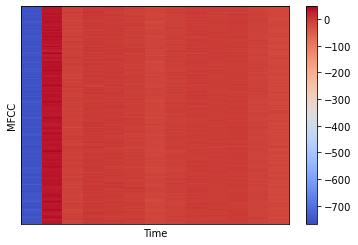

In [9]:
librosa.display.specshow(mfcc, sr=DOWN_SR, hop_length=hop_len)

plt.colorbar()
plt.xlabel("Time")
plt.ylabel("MFCC")

# Dataset

In [10]:
dataset_dir = Path("./datasets/segmentation/heartbeat-sounds-kaggle/")

In [11]:
df = pd.read_csv(dataset_dir / "set_a_timing.csv")
df

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992
...,...,...,...,...
385,set_a/normal__201108011118.wav,10,S2,284673
386,set_a/normal__201108011118.wav,11,S1,300863
387,set_a/normal__201108011118.wav,11,S2,314279
388,set_a/normal__201108011118.wav,12,S1,330980


In [29]:
n_fft = int(0.025 * DOWN_SR)
hop_len = int(0.01 * DOWN_SR)

data = {"mfccs": [], "labels": []}
class_to_int = {"S1": 0, "S2": 1}

for filename, group in df.groupby(["fname"]):
    print(f"processing file {filename}")
    file_path = dataset_dir / filename
    mfccs = process_audio_file(file_path, AUDIO_LEN)

    labels = [None] * len(mfccs) * len(mfccs[0])
    
    prev_class_idx = None
    for row_tuple in group[["sound", "location"]].itertuples():
        new_loc = int((int(row_tuple[2]) * DOWN_SR / DATA_SR) / hop_len)
        if new_loc < len(labels) - 1:
            if prev_class_idx is not None:
                labels[prev_class_idx + 1: new_loc + 1] = [class_to_int[row_tuple[1]]] * (new_loc - prev_class_idx)
            else:
                labels[0: new_loc + 1] = [class_to_int[row_tuple[1]]] * (new_loc + 1)
            
            prev_class_idx = new_loc
            
    if labels[-1] is None:
        labels[prev_class_idx + 1:] = [int(not labels[prev_class_idx])] * (len(labels) - prev_class_idx - 1)
    
    split_labels = []
    for i in range(len(mfccs)):
        split_labels.append(labels[i * len(mfccs[0]): (i + 1) * len(mfccs[0])])
    
    
    data["mfccs"] += mfccs
    data["labels"] += split_labels

processing file set_a/normal__201102081321.wav
processing file set_a/normal__201102260502.wav
processing file set_a/normal__201103090635.wav
processing file set_a/normal__201103140132.wav
processing file set_a/normal__201103140822.wav
processing file set_a/normal__201103151912.wav
processing file set_a/normal__201103221214.wav
processing file set_a/normal__201104141251.wav
processing file set_a/normal__201105011626.wav
processing file set_a/normal__201105021654.wav
processing file set_a/normal__201105021804.wav
processing file set_a/normal__201105151450.wav
processing file set_a/normal__201106111136.wav
processing file set_a/normal__201106141148.wav
processing file set_a/normal__201106210943.wav
processing file set_a/normal__201106221418.wav
processing file set_a/normal__201106221450.wav
processing file set_a/normal__201108011112.wav
processing file set_a/normal__201108011114.wav
processing file set_a/normal__201108011115.wav
processing file set_a/normal__201108011118.wav


In [ ]:
with open(output_path, "w") as f:
    json.dump(data, f, indent=4)